## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import numpy as np

## Read result data from backbone experiment

In [2]:
df_maize_ear = pd.read_csv('../ExperimentData/BackboneExperimentData/MaizeEar_results_per_mask.csv')
df_maize_uav = pd.read_csv('../ExperimentData/BackboneExperimentData/MaizeUAV_results_per_mask.csv')
df_soil = pd.read_csv('../ExperimentData/BackboneExperimentData/Soil_results_per_mask.csv')

df = pd.concat([df_maize_ear, df_maize_uav, df_soil], ignore_index=True)
df['Mask N'] = df['Mask N'].astype('category')
df['Sam generation'] = df['Sam generation'].astype(str)
df['Dataset'] = df['Dataset'].apply(lambda x: os.path.basename(x))
df['Sam update'] = df['Sam generation']
df.loc[df['Weights path'].str.contains('2.1_'),'Sam update'] = '2.1'

rename_dict = {'sam_vit_b_01ec64.pth': 'vit b',
                'sam_vit_l_0b3195.pth': 'vit l',
                'sam_vit_h_4b8939.pth': 'vit h',
                'sam2_hiera_tiny.pt'  : 'tiny',
                'sam2_hiera_small.pt' : 'small',
                'sam2_hiera_base_plus.pt': 'base +',
                'sam2_hiera_large.pt': 'large', 
                'sam2.1_hiera_tiny.pt': 'tiny', 
                'sam2.1_hiera_small.pt': 'small',
                'sam2.1_hiera_base_plus.pt' : 'base +', 
                'sam2.1_hiera_large.pt': 'large'}

df['Weights path'] = df['Weights path'].replace(rename_dict)
df.rename(columns={'Weights path': 'Backbone'})
print(df.head())
print(df.keys())
print(df['Weights path'].unique())
print(df.dtypes)
print(df['Sam generation'].unique())

#df_maize_uav.describe()
#df_soil.describe()

   Dice per mask  Gdice per mask  IoU per mask Mask N Sam generation  \
0       0.970217        0.942568      0.943671      0              1   
1       0.973768        0.949315      0.950069      1              1   
2       0.969670        0.941686      0.942684      2              1   
3       0.977234        0.955906      0.956390      3              1   
4       0.977769        0.957007      0.957372      4              1   

  Weights path   Dataset Sam update  
0        vit b  MaizeEar          1  
1        vit b  MaizeEar          1  
2        vit b  MaizeEar          1  
3        vit b  MaizeEar          1  
4        vit b  MaizeEar          1  
Index(['Dice per mask', 'Gdice per mask', 'IoU per mask', 'Mask N',
       'Sam generation', 'Weights path', 'Dataset', 'Sam update'],
      dtype='object')
['vit b' 'vit l' 'vit h' 'tiny' 'small' 'base +' 'large']
Dice per mask      float64
Gdice per mask     float64
IoU per mask       float64
Mask N            category
Sam generation  

## Data visualization

In [11]:
def read_sign_letters(file_paths: list[str]):
    dset_dfs = []
    dset_names = {'MED': 'MaizeEar', 'MUD':'MaizeUAV', 'SOD':'Soil'} 
    for file_path in file_paths:
        df_dset = pd.read_csv(file_path)
        dset_name = file_path.split('Letters')[-1].split('.csv')[0]
        df_dset['Dataset'] = dset_name
        dset_dfs.append(df_dset)
    df_conc = pd.concat(dset_dfs, ignore_index=True)
    df_conc['Dataset'] = df_conc['Dataset'].replace(dset_names)
    return df_conc

def get_violin_plot(df, xkey, ykey, colour_key):
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure(dpi=200)
    sns.violinplot(data=df, x=xkey, y=ykey, hue=colour_key, color='#2fb2b2') # Smart agricultural technology color "#2fb2b2"
    plt.show()
    
def get_box_plot(df, xkey, ykey, colour_key, grid_key):
    plt.rcParams["font.family"] = "Times New Roman"
    
    g = sns.FacetGrid(df, height=7, col=grid_key, sharex=False, sharey=True)
    g.figure.set_dpi(150)
    g.map_dataframe(sns.boxplot, x=xkey, y=ykey, hue=colour_key, palette='viridis', width=0.5)  # Set width to 0.5
    g.figure.subplots_adjust(wspace=0, hspace=0)
    for label, ax in g.axes_dict.items():
        ax.set_title('')  # remove the title generated by sns.FacetGrid
        ax.set_xlabel(label)  # use the label from the dataframe as xlabel
        if label == '1':
            ax.legend(loc='upper right')
        elif label == '2':
            ax.yaxis.set_visible(False)
            print("")

    plt.ylim(0, 1)
    plt.show()

def _draw_text(ax, x, y, text):
    if not pd.isna(text):
        ax.text(x, y, text, horizontalalignment='center', size='medium', color='black', weight='semibold')

def get_box_plot_plt(df, xkey, ykey, colour_key, col_key, row_key, df_sign_letters: pd.DataFrame = None):
    custom_cmap1 = sns.color_palette(['#aa4499']) #alterively from https://davidmathlogic.com/colorblind/ : '#332288'
    custom_cmap2 = sns.color_palette(['#117733', '#44aa99']) #   '#45a677', '#3c6582'
   
    plt.rcParams["font.family"] = "Times New Roman"
    fig = plt.figure(dpi=150, figsize=(8, 11)) 
    gs = fig.add_gridspec(ncols=3, nrows=3, wspace=0, hspace=0)
    legend_handles = []
    for i, row_title in enumerate(df[row_key].unique()):
        df_row = df[df[row_key] == row_title]
        for j, col_title in enumerate(df[col_key].unique()):
            df_col = df_row[df_row[col_key] == col_title]
            if col_title == "1":
                ax = fig.add_subplot(gs[i, j])
                box_width = 0.6
                palette = custom_cmap1
    
            elif col_title == "2":
                ax = fig.add_subplot(gs[i, j:])
                ax.yaxis.set_visible(False)
                box_width = 0.8
                palette = custom_cmap2
                

            bp = sns.boxplot(data=df_col, 
                             x=xkey, 
                             y=ykey, 
                             hue=colour_key, 
                             ax=ax, 
                             width=box_width, 
                             palette=palette,  
                             legend=False, 
                             flierprops={"marker": ".", "markerfacecolor": "white", "markersize": 4})
            
            if len(legend_handles) < 3:
                for i, sam_update in enumerate (df_col[colour_key].unique()):
                    legend_handles.append(mpatches.Patch(color=palette[i],label=sam_update))
               
            ax.set_xlabel('')
            ax.set_ylabel(row_title)
            ax.set_ylim(0, 1.15)
            ax.set_yticks(np.arange(0, 1.2, 0.2))
            if df_sign_letters is not None:
                sign_letters0 = df_sign_letters.loc[df_sign_letters['Dataset'] == row_title]
                sign_letters = sign_letters0['letter'].to_list()
                if col_title == "1":
                    offset = 0
                    group_split = False
                elif col_title == "2":
                    offset = 3
                    group_split = True
                for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
                    if group_split:
                        _draw_text(ax, tick - box_width * 0.25, 1.07, sign_letters[tick + offset])
                        offset += 1
                        _draw_text(ax, tick + box_width * 0.25, 1.07, sign_letters[tick + offset])
                        
                    else:
                        _draw_text(ax, tick, 1.07, sign_letters[tick])
                if i == 2 and j == 1:
                    ax.legend(handles=legend_handles, loc='lower right').set_title('SAM version')

    
    gs.figure.supylabel(ykey)


def get_swarm_plot(df, xkey, ykey, colour_key):
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure(dpi=200)
    sns.swarmplot(data=df, x=xkey, y=ykey, hue=colour_key, color='#2fb2b2')
    plt.show()

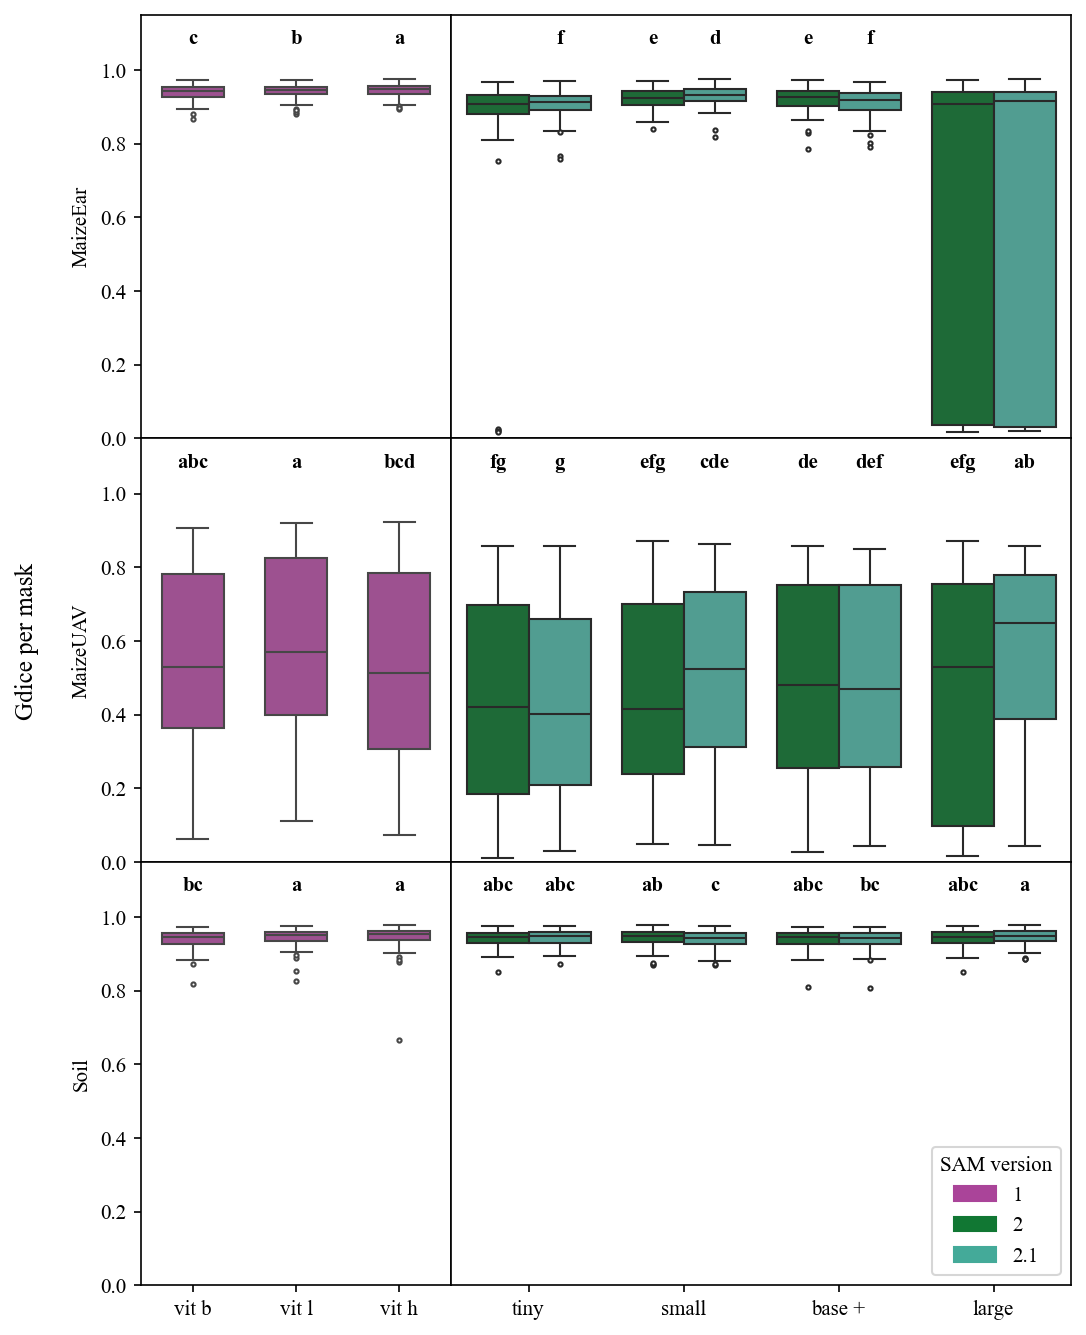

In [12]:
df_sign_letters = read_sign_letters(['SignLettersMED.csv', 'SignLettersMUD.csv', 'SignLettersSOD.csv'])

get_box_plot_plt(df, 'Weights path', 'Gdice per mask', 'Sam update', 'Sam generation', 'Dataset', df_sign_letters)
#get_box_plot(df.loc[df["Dataset"]=="MaizeUAV"], 'Weights path', 'Gdice per mask', 'Sam generation')
#get_box_plot(df.loc[df["Dataset"]=="Soil"], 'Weights path', 'Gdice per mask', 'Sam generation')